<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [89]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from matplotlib.axis import Axis
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
import pandas as pd


In [ ]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []
mylist = os.listdir(path)

#print(mylist)	



In [ ]:
print(len(mylist))

4642


LABLES

In [ ]:
import re

feeling_list=[]
dataset = ''

for item in mylist:
    file_label = item[6:-16]
    try:
      file_label = int(file_label)
      dataset = 'RAVDESS'
    except:
      if (item[:1] == 'Y') or (item[:1] == 'O'):
        file_label = re.split('_|\.', item)[2]
        dataset = 'TESS'
      else: dataset = 'SAVEE'

    if dataset == 'RAVDESS':
      if int(item[18:-4])%2==0:  #female
          if file_label == 1:
            feeling_list.append('female_neutral')
          elif file_label == 2:
            feeling_list.append('female_calm')
          elif file_label == 3:
            feeling_list.append('female_happy')
          elif file_label == 4:
            feeling_list.append('female_sad')
          elif file_label == 5:
            feeling_list.append('female_angry')
          elif file_label == 6:
            feeling_list.append('female_fearful')
          elif file_label == 7:
            feeling_list.append('female_disgust')
          elif file_label == 8:
            feeling_list.append('female_surprised')
      else:
          if file_label== 1:
            feeling_list.append('male_neutral')
          elif file_label == 2:
            feeling_list.append('male_calm')
          elif file_label == 3:
            feeling_list.append('male_happy')
          elif file_label == 4:
            feeling_list.append('male_sad')
          elif file_label == 5:
            feeling_list.append('male_angry')
          elif file_label == 6:
            feeling_list.append('male_fearful')
          elif file_label == 7:
            feeling_list.append('male_disgust')
          elif file_label == 8:
            feeling_list.append('male_surprised')

    elif dataset == 'TESS':
      if file_label == 'neutral': feeling_list.append('female_neutral')
      elif file_label == 'angry': feeling_list.append('female_angry')
      elif file_label == 'disgust': feeling_list.append('female_disgust')
      elif file_label == 'ps': feeling_list.append('female_surprised')
      elif file_label == 'happy': feeling_list.append('female_happy')
      elif file_label == 'sad': feeling_list.append('female_sad')
      elif file_label == 'fear': feeling_list.append('female_fearful')

    elif dataset == 'SAVEE':
      if item[:1]=='a':
        feeling_list.append('male_angry')
      elif item[:1]=='f':
        feeling_list.append('male_fearful')
      elif item[:1]=='h':
        feeling_list.append('male_happy')
      elif item[:1]=='n':
        feeling_list.append('male_neutral')
      elif item[:2]=='sa':
        feeling_list.append('male_sad')
      elif item[:2]=='su':
        feeling_list.append('male_surprised')
      elif item[:1]=='d':
        feeling_list.append('male_disgust')


In [ ]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels #[1600:1660]      #print

,0
0,female_fearful
1,female_surprised
2,female_disgust
3,female_fearful
4,female_angry
...,...
4637,male_sad
4638,male_neutral
4639,male_neutral
4640,male_happy


Getting the features of audio files using librosa

In [90]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # 40 values 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # 12 values 
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # 128 values 
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast)) # 7 values 
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # 6 values 

    return result

#f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
#a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
#print(a, a.shape)

In [ ]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+ y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [ ]:
data_frame

,all_features
0,"[-316.3982820454405, 39.7822605437439, -19.189..."
1,"[-342.88055472969165, 45.95027168893386, -12.3..."
2,"[-419.17375831355355, 79.36795418715639, 4.317..."
3,"[-293.87641633233585, 22.448290415751732, -9.3..."
4,"[-367.20304493461066, 40.17211376308315, -2.72..."
...,...
4637,"[-386.0892486848382, 110.02557215362587, 21.23..."
4638,"[-442.40133523714957, 112.92528455032522, 34.9..."
4639,"[-422.7050269459787, 120.85873358076398, 28.69..."
4640,"[-302.1125750691463, 111.5075339801829, 5.2672..."


In [ ]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001503,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,0.004468,0.006076,0.005546,0.006286,0.006116,0.011182,0.018300,0.012381,0.005446,0.009796,0.008335,0.003382,0.000305,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.002129,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,0.004420,0.007988,0.007283,0.005904,0.006900,0.006846,0.008745,0.006972,0.003461,0.003092,0.003775,0.002511,0.000264,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000393,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,0.001152,0.001685,0.002630,0.003414,0.003983,0.005403,0.007188,0.004412,0.001615,0.002020,0.003231,0.001068,0.000168,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.133340,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,0.030698,0.035535,0.035312,0.031429,0.029649,0.039931,0.044069,0.031701,0.013745,0.018371,0.012888,0.005912,0.000552,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000616,0.000405,0.000610,0.000777,0.000929,0.002041,0.001509,0.001979,0.001734,0.002036,0.002950,0.004354,0.002887,0.003199,0.004200,0.007140,0.007721,0.006963,0.009832,0.018136,0.027777,0.011011,0.006270,0.011737,0.012987,0.008119,0.000792,18.718335,21.817464,23.389298

In [ ]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels    #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,4.467806e-03,6.076175e-03,5.545964e-03,6.285772e-03,6.115529e-03,1.118162e-02,1.830000e-02,1.238102e-02,5.446300e-03,9.795647e-03,8.335074e-03,3.382275e-03,3.049260e-04,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189,female_fearful
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,4.419637e-03,7.988392e-03,7.282747e-03,5.903650e-03,6.899837e-03,6.846244e-03,8.745193e-03,6.971703e-03,3.461123e-03,3.091562e-03,3.774827e-03,2.511465e-03,2.638007e-04,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161,female_surprised
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,1.152094e-03,1.684913e-03,2.629799e-03,3.414122e-03,3.983024e-03,5.403495e-03,7.188147e-03,4.411572e-03,1.614888e-03,2.019921e-03,3.231404e-03,1.068011e-03,1.677236e-04,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304,female_disgust
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,3.069844e-02,3.553510e-02,3.531232e-02,3.142908e-02,2.964862e-02,3.993142e-02,4.406870e-02,3.170089e-02,1.374528e-02,1.837071e-02,1.288842e-02,5.912021e-03,5.524261e-04,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230,female_fearful
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000405,0.000610,0.000777,0.000929,0.00

In [ ]:
from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)
data_frame_labels
    #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
4297,-386.650391,112.257884,32.538729,55.920757,-11.472445,-6.594399,1.843466,3.526906,-9.719948,0.272446,-1.445023,-3.198936,-0.375138,-0.255478,6.328461,0.563520,-0.351230,1.548781,0.207166,-4.937928,1.837546,4.244088,-1.562167,-2.103844,0.455603,-2.398293,0.779373,4.251547,-1.899298,-1.610627,2.444678,3.864808,2.629697,0.894058,2.185032,1.397219,0.770842,2.446485,2.546150,1.161653,...,0.003463,0.003928,0.004474,0.004706,0.003627,0.002137,0.001433,0.001461,0.001296,0.001115,0.000800,0.000628,0.000380,0.000146,0.000079,0.000037,0.000022,0.000007,1.178434e-06,2.218054e-07,1.456940e-07,1.695652e-07,2.150158e-07,3.132837e-07,4.433140e-07,4.937361e-07,31.907075,14.005291,17.960368,19.927870,19.911672,21.453665,41.467029,0.004777,0.006754,-0.010323,0.021967,-0.006128,0.000325,male_neutral
834,-299.239255,30.882220,-7.624576,10.072476,2.918595,7.535072,7.858384,-3.801196,-3.628800,7.648708,-16.975320,9.263544,-2.766942,5.553412,1.373609,-5.312648,2.379411,10.954330,-7.677073,9.850016,1.903584,0.239441,-1.386426,1.123141,-4.174776,5.694065,-1.530366,1.730373,-0.904936,2.925451,-0.481910,8.660168,-1.469448,1.411537,-3.667900,3.204587,-1.019160,1.440307,-0.777350,1.583379,...,0.002249,0.002680,0.004001,0.004094,0.005872,0.004991,0.006134,0.005321,0.005888,0.003499,0.003331,0.003257,0.004754,0.005569,0.008002,0.009688,0.009170,0.008838,1.496371e-02,1.553523e-02,1.079949e-02,1.221468e-02,9.453340e-03,7.553417e-03,4.292128e-03,5.638074e-04,14.940984,20.068666,22.954760,18.938000,19.845712,22.225938,32.173067,-0.003287,0.011098,-0.023515,0.002380,0.002589,0.006072,female_fearful
3244,-631.708227,57.812441,-4.768079,16.799045,8.447084,-2.606081,-2.490354,-16.618601,-6.383768,3.015490,-4.969042,-2.969460,0.419781,1.585797,0.444348,-0.217427,-2.728774,6.449055,3.834710,7.104997,5.449810,6.690715,4.682529,10.976344,6.711400,7.975050,3.219573,7.475042,5.194706,4.736429,2.526778,2.135177,0.510637,2.935238,1.255736,2.274014,0.220092,1.068158,-1.494288,-0.523183,...,0.000014,0.000010,0.000007,0.000010,0.000008,0.000007,0.000008,0.000010,0.000011,0.000012,0.000011,0.000009,0.000007,0.000005,0.000005,0.000006,0.000005,0.000003,7.796216e-06,1.226196e-05,1.306513e-05,1.055138e-05,6.419980e-06,5.745188e-06,2.226130e-06,1.491235e-07,19.643638,17.510712,17.153081,16.500626,17.249775,18.054792,29.422410,-0.033702,0.019052,0.042628,-0.013429,0.021452,0.024160,female_sad
2640,-374.523802,68.953669,-6.685906,-11.386214,-19.893413,-8.508675,-19.998765,5.392508,-20.501850,-2.425175,-7.795433,4.309095,-4.337402,7.363466,-1.212704,-1.221640,3.182487,-7.681467,-3.607773,-14.531074,-8.442779,4.721248,1.504575,25.715152,31.718579,30.731710,23.506435,13.048573,-5.005679,2.128138,5.324190,7.924119,4.545379,-5.735838,1.562780,4.584207,1.656216,5.483671,-4.200719,-1.019264,...,0.001048,0.001063,0.000943,0.000927,0.000844,0.001453,0.002571,0.001788,0.003070,0.004082,0.003551,0.003179,0.002320,0.001538,0.001574,0.001422,0.001464,0.000897,5.048423e-04,3.514573e-04,2.229529e-04,1.441629e-04,1.475965e-04,1.462321e-04,5.302817e-05,2.691927e-06,27.402455,26.814298,28.764361,26.920250,26.024028,22.117023,34.723547,-0.009678,0.002519,-0.096969,-0.020635,0.007121,-0.010030,female_angry
4456,-387.594077,98.339948,11.329239,38.251268,19.280561,3.486709,-20.510567,-0.764894,-1.724635,-10.851204,3.536598,1.194512,-1.376731,-0.048999,7.186931,-2.778921,-2.712673,6.793405,-1.030662,-1.296969,-0.225800,-0.507843,1.198158,-1.930688,-0.527245,-2.198799,-1.828542,1.749463,-1.271855,0.246354,2.280063,2.205477,4.471838,8.225115,13.212310,15.069090,12.131318,7.867216,4.898035,4.327289,...,0.004526,0.004354,0.003556,0.002637,0.002151,0.000833,0.000293,0.000210,0.000112,0.000106,0.000065,0.000043,0.000024,0.000012,0.000008,0

SAVE DATASET FEATURES AND LABELS 

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


LOAD DATASET FEATURES AND LABELS 

In [91]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


Dividing the data into test and train

In [92]:
data_frame_labels.rename(columns={'0': 'lables'}, inplace=True)

data_frame_labels.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  30,  31,  32,  33,  34,  35, 36,  37,  38,  39,  40 , 41,  42,  43,  44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52,  53, 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67,  68,  69 , 70 , 71 ,72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80  ,81 , 82 , 83  ,84 , 85 , 86 , 87 , 88 , 89 ,90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 ,100 ,101 ,102 ,103 ,104, 105 ,106, 107, 108, 109, 110 ,111, 112 ,113, 114, 115 ,116 ,117 ,118, 119, 120, 121, 122, 123 ,124 ,125 ,126, 127, 128 ,129 ,130 ,131 ,132, 133 ,134, 135 ,136 ,137 ,138 ,139, 140 ,141 ,142 ,143, 144 ,145, 146 ,147 ,148, 149, 150, 151, 152, 153 ,154, 155, 156 ,157 ,158 ,159 ,160, 161 ,162, 163, 164 ,165 ,166 ,167 ,168 ,169 ,170, 171, 172 ,173 ,174 ,175, 176, 177 ,178 ,179 ,180, 181, 182, 183, 184, 185 ,186 ,187 ,188 ,189 ,190 ,191 ,192 , 'lables']
print(data_frame_labels)

data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_neutral']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_calm']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_fearful']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_surprised']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_happy']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_sad']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_angry']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'male_disgust']
print(data_frame_labels)

data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 0.8

train = data_frame_labels[data_frame_labels_set]
test = data_frame_labels[~data_frame_labels_set]





               0           1          2  ...       191       192          lables
4297 -386.650391  112.257884  32.538729  ... -0.006128  0.000325    male_neutral
834  -299.239255   30.882220  -7.624576  ...  0.002589  0.006072  female_fearful
3244 -631.708227   57.812441  -4.768079  ...  0.021452  0.024160      female_sad
2640 -374.523802   68.953669  -6.685906  ...  0.007121 -0.010030    female_angry
4456 -387.594077   98.339948  11.329239  ... -0.001085 -0.006170        male_sad
...          ...         ...        ...  ...       ...       ...             ...
3529 -693.176415   67.552259  13.179828  ...  0.013614  0.003542        male_sad
86   -308.411276   24.759349  -8.787251  ... -0.004993 -0.006506  female_fearful
1168 -401.165881   41.204870   0.116705  ... -0.022335  0.010550  female_neutral
339  -351.016867   31.839028   3.526565  ...  0.003630  0.009189    female_angry
3558 -747.555344   37.940025   6.687089  ... -0.004560  0.021784     female_calm

[4642 rows x 194 columns]
 

In [39]:
test[0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,lables
3244,-631.708227,57.812441,-4.768079,16.799045,8.447084,-2.606081,-2.490354,-16.618601,-6.383768,3.015490,-4.969042,-2.969460,0.419781,1.585797,0.444348,-0.217427,-2.728774,6.449055,3.834710,7.104997,5.449810,6.690715,4.682529,10.976344,6.711400,7.975050,3.219573,7.475042,5.194706,4.736429,2.526778,2.135177,0.510637,2.935238,1.255736,2.274014,0.220092,1.068158,-1.494288,-0.523183,...,0.000014,0.000010,0.000007,0.000010,0.000008,0.000007,0.000008,0.000010,0.000011,0.000012,0.000011,0.000009,0.000007,0.000005,0.000005,0.000006,0.000005,0.000003,0.000008,0.000012,0.000013,0.000011,0.000006,0.000006,0.000002,1.491235e-07,19.643638,17.510712,17.153081,16.500626,17.249775,18.054792,29.422410,-0.033702,0.019052,0.042628,-0.013429,0.021452,0.024160,female_sad
2190,-409.296245,84.246086,-3.065469,-9.654765,3.080720,1.016595,-12.238992,3.584806,-13.699678,2.425779,-12.156512,-4.024573,-4.394760,2.141418,1.634106,4.529132,-4.697738,9.815881,0.429411,0.445322,0.990792,4.808037,-4.849594,6.484125,-3.807935,3.542407,-2.026937,0.820234,-0.275711,4.868101,-0.814554,3.264771,-1.078590,2.732507,3.052313,9.221830,11.671367,15.812766,13.444153,13.973885,...,0.001083,0.001588,0.001390,0.001641,0.001418,0.001547,0.002227,0.001979,0.001051,0.000742,0.000965,0.000894,0.000731,0.000494,0.000607,0.000619,0.000737,0.001084,0.001257,0.001026,0.001037,0.000732,0.000827,0.000534,0.000143,6.391692e-06,26.145972,19.813364,20.202091,18.217001,20.025601,18.693082,31.940087,-0.003132,0.022258,-0.052415,-0.024351,-0.001703,0.015905,female_surprised
1968,-412.899210,47.657537,-2.642432,-13.275479,-11.464555,2.412070,-16.540559,-6.133570,-16.072267,1.711751,-5.043289,5.214067,-3.234738,5.036070,0.611361,1.803193,-9.821405,-4.568172,-8.265517,-9.020011,-0.181015,10.723191,11.735174,24.081024,19.438414,18.289127,7.953505,11.214322,9.773816,13.712398,10.055011,9.776409,-2.504767,5.579145,4.979517,2.615228,-0.392765,1.518186,-0.023285,6.570122,...,0.000839,0.001173,0.001147,0.001092,0.001394,0.001952,0.002463,0.001733,0.001744,0.002485,0.003091,0.005761,0.002802,0.001503,0.001282,0.000709,0.000860,0.000530,0.000317,0.000400,0.000328,0.000249,0.000312,0.000246,0.000037,1.214485e-06,29.720241,25.727877,26.490537,21.934901,21.913099,19.616016,34.906006,0.004165,0.024124,0.059838,-0.044958,-0.016099,0.007053,female_angry
102,-331.357299,14.493875,9.908884,36.420893,-1.540338,-8.364388,-2.383773,-10.624915,-7.216132,-10.178539,-10.693040,11.134203,-15.190269,7.909069,-3.628360,-2.378465,5.400514,-0.151204,-6.061658,4.722254,-10.381118,-0.866908,-3.396429,8.360518,7.980695,8.357558,5.313227,5.968835,3.893949,7.985436,1.357442,2.550244,0.418549,2.776770,4.739392,7.424055,2.230894,0.080587,-7.015144,-0.998650,...,0.018343,0.001227,0.001018,0.000999,0.002091,0.002083,0.002201,0.003360,0.003014,0.004120,0.003321,0.003410,0.004740,0.005570,0.006509,0.007089,0.007006,0.007287,0.008276,0.011397,0.006589,0.004336,0.004396,0.005381,0.002823,2.799308e-04,14.467550,22.215303,24.966503,19.169648,22.188522,22.312694,33.555950,0.006149,-0.006314,0.031604,-0.032067,-0.004779,-0.013166,female_happy
1700,-523.542224,57.300975,22.829340,13.251600,10.181799,6.955352,-3.736466,-6.382372,-13.046391,0.308675,-10.224062,3.915587,-3.936880,6.091512,6.898970,5.210054,-1.528509,9.877365,-4.027332,-0.922501,0.441446,2.399390,-6.149971,3.849355,-8.548121,-1.481232,-6.107484,2.173653,-4.368186,-1.206394,-7.239962,0.699201,-6.844682,2.826612,14.111218,24.102234,33.154223,35.262061,21.113867,14.604688,...,0.000134,0.000077,0.000058,0.000060,0.000097,0.000142,0.000118,0.000139,0.000112,0.000103,0.000133,0.000199,0.000164,0.000102,0.000130,0.000120,0.000123,0.000125,0.000072,0.000073,0.000073,0.000061,0.000044,0.000035,0.000014,1.049

In [93]:
i = 0
tess_count = 0
savee_count = 0
ravdess_count = 0
for i in test:
  index = int(test.iloc[i].name)
  if index < 1400: tess_count = tess_count + 1
  elif index < 1550: savee_count = savee_count + 1
  elif index < 2950: tess_count = tess_count + 1
  elif index < 3331: savee_count = savee_count + 1
  elif index < 4643: ravdess_count = ravdess_count + 1
  else: print('hui')
  #print(dataset)
  #print(test.iloc[i].name) # thats the index of the file (useful for datasets acc prediction visualization)
print("tess")
print(tess_count)
print('ravdess')
print(ravdess_count)
print('savee')
print(savee_count)

TypeError: ignored

In [94]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [95]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]
testlabel

,lables
3244,female_sad
1195,female_disgust
1777,female_disgust
2190,female_surprised
2675,female_sad
...,...
1343,female_disgust
1920,female_angry
194,female_angry
2925,female_neutral


In [96]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

#print(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [45]:
X_test

array([[-6.31708227e+02,  5.78124405e+01, -4.76807885e+00, ...,
        -1.34287940e-02,  2.14516283e-02,  2.41602477e-02],
       [-4.09296245e+02,  8.42460863e+01, -3.06546857e+00, ...,
        -2.43510601e-02, -1.70309243e-03,  1.59052734e-02],
       [-4.12899210e+02,  4.76575369e+01, -2.64243157e+00, ...,
        -4.49576370e-02, -1.60986365e-02,  7.05275120e-03],
       ...,
       [-7.09659833e+02,  3.29835829e+01, -5.67741819e+00, ...,
         3.12163521e-02, -1.72821938e-03,  2.06620007e-02],
       [-5.38836441e+02,  3.62024607e+01, -2.31380557e+01, ...,
         1.75494289e-02,  2.02278189e-03,  2.76175773e-03],
       [-3.51016867e+02,  3.18390276e+01,  3.52656531e+00, ...,
        -1.72718186e-02,  3.62955380e-03,  9.18946635e-03]])

Changing dimension for CNN model

In [97]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-6.31708227e+02]
  [ 5.78124405e+01]
  [-4.76807885e+00]
  ...
  [-1.34287940e-02]
  [ 2.14516283e-02]
  [ 2.41602477e-02]]

 [[-4.05668159e+02]
  [ 7.65023514e+01]
  [ 1.40133347e+01]
  ...
  [-4.31035448e-02]
  [ 4.69869340e-03]
  [ 4.11917974e-03]]

 [[-4.35165110e+02]
  [ 8.82021345e+01]
  [ 2.24771598e+01]
  ...
  [ 8.11673375e-03]
  [ 1.43469601e-03]
  [-2.75847533e-03]]

 ...

 [[-3.42842353e+02]
  [ 5.68329015e+00]
  [ 2.04965171e+00]
  ...
  [-3.29411728e-02]
  [ 7.25951567e-03]
  [ 2.72038554e-03]]

 [[-7.09659833e+02]
  [ 3.29835829e+01]
  [-5.67741819e+00]
  ...
  [ 3.12163521e-02]
  [-1.72821938e-03]
  [ 2.06620007e-02]]

 [[-4.85593954e+02]
  [ 2.51185129e+01]
  [-1.49222401e+01]
  ...
  [ 3.73957898e-03]
  [ 5.33875469e-03]
  [ 6.86734785e-03]]]


In [32]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same', input_shape=(193,1)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=(4)))
model.add(Dropout(0.1))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(8))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 193, 256)          1536      
_________________________________________________________________
activation_14 (Activation)   (None, 193, 256)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 193, 128)          163968    
_________________________________________________________________
activation_15 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 193, 128)          82048     
_________________________________________________________________
activation_16 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 193, 128)         

In [47]:
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

Removed the whole training part for avoiding unnecessary long epochs list

In [49]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size = 32, epochs = 50, validation_data = (x_testcnn, y_test))

Epoch 1/50
88/88 [==============================] - 41s 468ms/step - loss: 0.2490 - accuracy: 0.9102 - val_loss: 0.3918 - val_accuracy: 0.8776
Epoch 2/50
88/88 [==============================] - 41s 464ms/step - loss: 0.2231 - accuracy: 0.9255 - val_loss: 0.4211 - val_accuracy: 0.8640
Epoch 3/50
88/88 [==============================] - 41s 463ms/step - loss: 0.2256 - accuracy: 0.9216 - val_loss: 0.3599 - val_accuracy: 0.8807
Epoch 4/50
88/88 [==============================] - 41s 463ms/step - loss: 0.2005 - accuracy: 0.9283 - val_loss: 0.4215 - val_accuracy: 0.8671
Epoch 5/50
88/88 [==============================] - 41s 461ms/step - loss: 0.1962 - accuracy: 0.9301 - val_loss: 0.3417 - val_accuracy: 0.8837
Epoch 6/50
88/88 [==============================] - 41s 465ms/step - loss: 0.2023 - accuracy: 0.9294 - val_loss: 0.3405 - val_accuracy: 0.8792
Epoch 7/50
88/88 [==============================] - 41s 471ms/step - loss: 0.1770 - accuracy: 0.9383 - val_loss: 0.4004 - val_accuracy: 0.8776

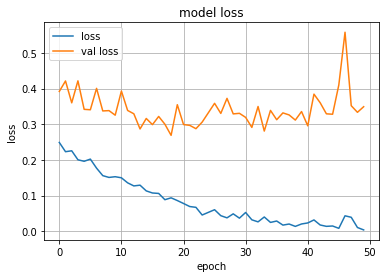

In [50]:
plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['loss', 'val loss'], loc='upper left')
plt.show()

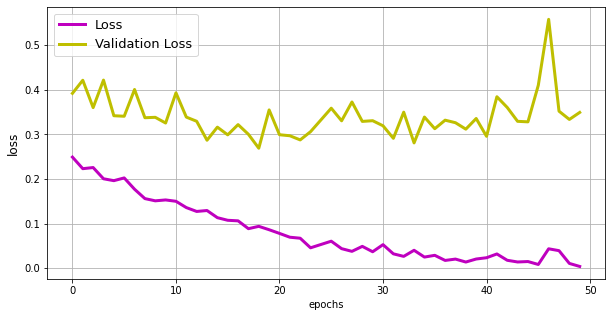

In [51]:
plt.figure(figsize=(10,5))

plt.plot(cnnhistory.history['loss'], 'm', linewidth=3)
plt.plot(cnnhistory.history['val_loss'], 'y', linewidth=3)
plt.legend(['Loss', 'Validation Loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

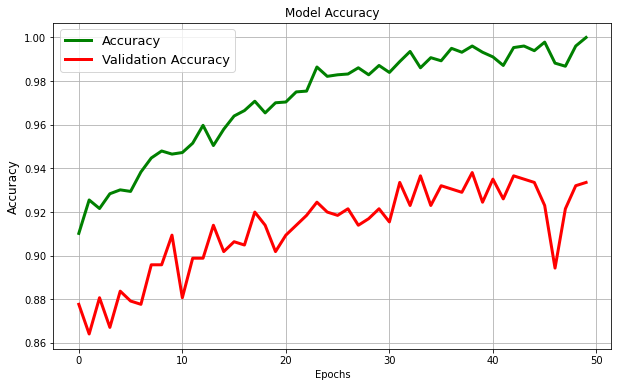

In [52]:
plt.figure(figsize=(10,6), frameon=True)

plt.plot(cnnhistory.history['accuracy'], 'g', linewidth=3)
plt.plot(cnnhistory.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)

plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

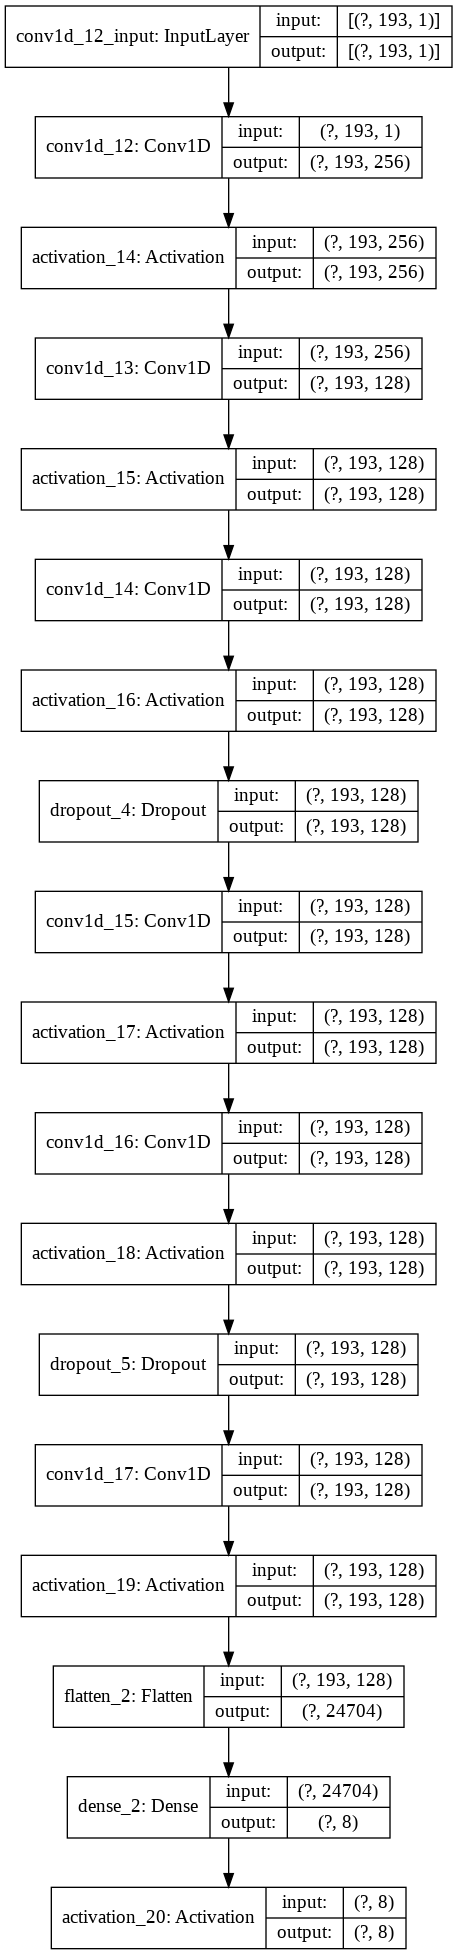

In [53]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_08_FEMALE.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


SAVING THE MODEL

In [54]:
model_name = 'Emotion_Voice_Detection_CNN_model_08_FEMALE.h5'
path = '/content/drive/My Drive/My_AI/MY MODELS/'
model_path = os.path.join(path, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_08_FEMALE.h5 


In [55]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/MY MODELS/model_08_FEMALE.json", "w") as json_file:
    json_file.write(model_json)

LOADING THE MODEL

In [98]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/MY MODELS/model_08_FEMALE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_08_FEMALE.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 98.34%


Predicting emotions on the test data

In [57]:
import pandas as pd

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[10:70]


21/21 [==============================] - 2s 106ms/step


,actualvalues,predictedvalues
10,female_fearful,female_fearful
11,female_surprised,female_surprised
12,female_angry,female_angry
13,female_disgust,female_disgust
14,female_angry,female_angry
15,female_disgust,female_disgust
16,female_disgust,female_sad
17,female_disgust,female_disgust
18,female_sad,female_sad
19,female_neutral,female_neutral


In [58]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,98
female_calm,17
female_disgust,98
female_fearful,92
female_happy,83
female_neutral,86
female_sad,96
female_surprised,92


In [59]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,102
female_calm,18
female_disgust,88
female_fearful,95
female_happy,82
female_neutral,87
female_sad,101
female_surprised,89


In [60]:
finaldf.to_csv('Predictions_08_FEMALE.csv', index=False)

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))


                  precision    recall  f1-score   support

    female_angry       0.93      0.97      0.95        98
     female_calm       0.83      0.88      0.86        17
  female_disgust       0.95      0.86      0.90        98
  female_fearful       0.91      0.93      0.92        92
    female_happy       0.94      0.93      0.93        83
  female_neutral       0.98      0.99      0.98        86
      female_sad       0.90      0.95      0.92        96
female_surprised       0.96      0.92      0.94        92

        accuracy                           0.93       662
       macro avg       0.92      0.93      0.93       662
    weighted avg       0.93      0.93      0.93       662



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


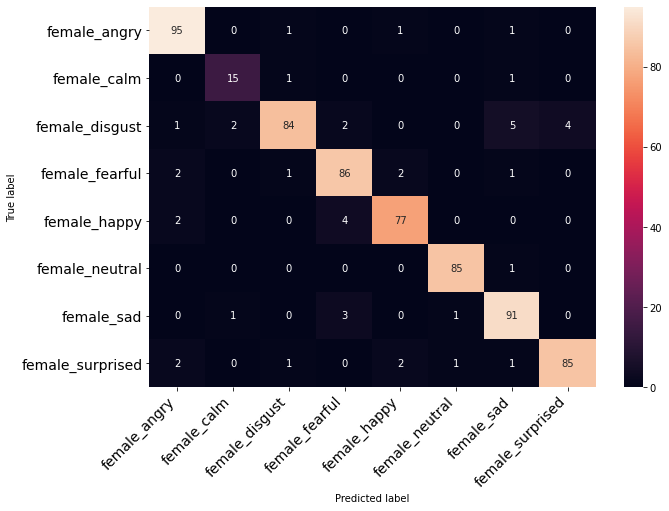

In [62]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fearful' or 'female_happy' or 'female_sad' or 'female_surprised' or 'female_neutral' or 'female_angry' or 'female_calm':
        return 'female'

finaldf = pd.read_csv("Predictions_08_FEMALE.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


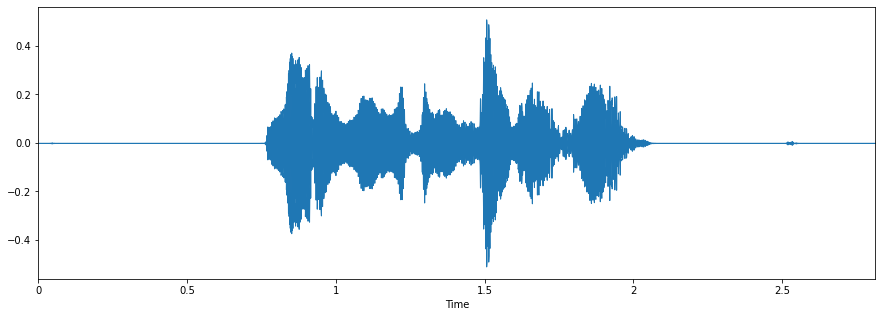

In [63]:
data, sampling_rate = librosa.load('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry-H (1).wav')

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [99]:
X, sample_rate = librosa.load('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry_.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry_.wav')
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)

In [100]:
features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

In [109]:
import torch
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose = 1)
print(live_preds)

all = np.argsort(-live_preds, axis=1)[:, :8]
for i in all:
  print((lb.inverse_transform((i))))

print()
print()
best_n = np.argsort(-live_preds)[:, :3]
print(best_n)
print()
print()

for n in best_n:
  print(live_preds[0][n])


for i in best_n:
  print((lb.inverse_transform((i))))


1/1 [==============================] - 0s 1ms/step
[[2.3460459e-05 3.5501910e-36 3.8291921e-07 2.1200609e-10 7.9929954e-08
  3.1103009e-05 6.3508472e-17 9.9994493e-01]]
['female_surprised' 'female_neutral' 'female_angry' 'female_disgust'
 'female_happy' 'female_fearful' 'female_sad' 'female_calm']


[[7 5 0]]


[9.999449e-01 3.110301e-05 2.346046e-05]
['female_surprised' 'female_neutral' 'female_angry']


In [108]:
"""
print('PROBABILITY:')
layer = tf.keras.layers.Softmax()
print(layer(live_preds).numpy())



live_preds = live_preds.argmax(axis = 1)
print(live_preds)
live_preds = live_preds.astype(int).flatten()

live_preds = (lb.inverse_transform((live_preds)))
live_preds
"""


# Angry
# 
# Disgust
# Fearful
# 
# Neutral
# Sad
# Surprised

me = 1
you = 0


me > you


True